# Alloy4Fun Data

## Import Data

In [221]:
import pandas as pd, os 
import matplotlib.pyplot as plt

def importDataFromDir(dir):
    # Import all the data from a directory
    # dir: directory with the data
    # return: a dictionary of dataframes
    dict = {}

    for file in os.listdir(dir):
        if file.endswith('.json'):
            df = pd.read_json(f'{dir}/' + file, lines=True)
            dict[file.removesuffix(".json")] = df
            print(f"Imported {file}.")

    return dict

def removeLogFiles():
    # Remove the log file
    try:
        os.remove("data/astError.txt")
        os.remove("data/drops.txt")
    except OSError:
        pass

In [222]:
removeLogFiles() # Remove the log file if exists
# Import files from the data directory
dict = importDataFromDir('data/submissions')

Imported 9jPK8KBWzjFmBx4Hb.json.
Imported FwCGymHmbqcziisH5.json.
Imported gAeD3MTGCCv8YNTaK.json.
Imported JC8Tij8o8GZb99gEJ.json.
Imported jyS8Bmceejj9pLbTW.json.
Imported PQAJE67kz8w5NWJuM.json.
Imported sDLK7uBCbgZon3znd.json.
Imported WGdhwKZnCu7aKhXq9.json.
Imported YH3ANm7Y5Qe5dSYem.json.
Imported zoEADeCW2b2suJB2k.json.
Imported zRAn69AocpkmxXZnW.json.


# Data analysis

Count number of submissions.

In [223]:
# Count total number of rows
total = 0
for key in dict:
    total += len(dict[key])
print(f"Total number of rows: {total}")

Total number of rows: 35224


Counter({1.0: 14714, 0.0: 10537, -1.0: 9606})


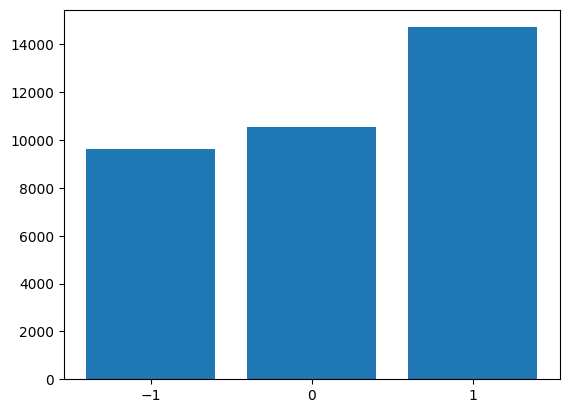

In [224]:
import collections

def countValues(dict, col):
    # Count the values in a column
    # df: dataframe
    # col: column to count
    # return: dataframe with the counts
    totalCount = collections.Counter()

    for df in dict.values():
        count = df[col].value_counts().to_dict()
        totalCount.update(count)        

    return totalCount

# Count the different valeus in the 'sat' column
counter = countValues(dict, 'sat')
print(counter)

# Plot the counts
plt.bar(counter.keys(), counter.values())       
plt.xticks([-1, 0, 1])
plt.show()

## Data Cleaning

### Separate challenge code from the rest of submissions

In [225]:
def separateChallengeRows(dict):
    # Separate the first row of each dataframe
    # dict: dictionary of dataframes
    # return: a dictionary of dataframes
    challengeRows = {}

    for key, df in dict.items():
        # Store the first row of each dataframe
        challengeRows[key] = df.head(1).copy()
        # Remove the first row from the dataframe
        df.drop(index=0, inplace=True)

    return challengeRows

challengeRows = separateChallengeRows(dict) 

# Check
challengeRows["9jPK8KBWzjFmBx4Hb"].head()

,_id,time,code,derivationOf,theme,original,cmd_i,cmd_c,cmd_n,sat,msg
0,9jPK8KBWzjFmBx4Hb,2019-10-31 10:28:19,/**\n * Linear temporal logic revision exercis...,cAMmPjLAFceP7dnod,{'sigSettings': {'nodeColors': [{'type': 'univ...,9jPK8KBWzjFmBx4Hb,NaN,NaN,NaN,NaN,NaN


In [226]:
for key, df in challengeRows.items():
    print(df["code"].values[0])

/**
 * Linear temporal logic revision exercises based on a simple model of a 
 * file system trash can.
 * 
 * Solve the following exercises using Electrum's temporal logic, which
 * extends first-order relational logic with:
 *	- unary future operators after, always and eventually
 *	- binary future operators until and releases
 *	- unary past operators before, historically and once
 *	- binary past operators since and triggered
 *  - primed relational expression e' 
 **/
var sig File {
	var link : lone File
}
var sig Trash in File {}
var sig Protected in File {}

// initially the trash is empty and there are no protected file
pred prop1 {

}

//SECRET
pred prop1o {
	no Trash+Protected
}

// initially there are no files, but some are immediately created
pred prop2 {

}

//SECRET
pred prop2o {
	no File and some File'
}

// there is always some file in the system
pred prop3 {

}

//SECRET
pred prop3o {
	always some File
}

// some file will eventually be sent to the trash
pred prop4 {



### Check null values

In [227]:
df1 = dict["9jPK8KBWzjFmBx4Hb"]
df1.isnull().sum()

_id                0
time               0
code               0
derivationOf       0
theme           5242
original           0
cmd_i             36
cmd_c            926
cmd_n            926
sat               36
msg             4368
dtype: int64

Features meaning:
- _id: the id of the interaction
- time: the timestamp of its creation
- derivationOf: the parent entry
- original: the first ancestor with secrets (always the same within an exercise)
- code: the complete code of the model (excluding the secrets defined in the original entry) (with student comments removed)
- sat: whether the command was satisfiable (counter-example found for checks), or -1 when error thrown [only for executions]
- cmd_i: the index of the executed command [only for executions]
- cmd_n: the name of the executed command [only for successful executions, i.e. no error thrown]
- cmd_c: whether the command was a check [only for successful executions, i.e. no error thrown]
- msg: the error or warning message [only for successful executions with warnings or when error thrown]
- theme: the visualisation theme [only for sharing entries

#### cmd_i null values

cmd_i is null for non-executions. 

In [228]:
# Filter rows with cmd_i = null
nullDF = df1[df1["cmd_i"].isnull()]
nullDF.head()

,_id,time,code,derivationOf,theme,original,cmd_i,cmd_c,cmd_n,sat,msg
1022,P3gFuEkajduWTyFeo,2019-10-31 11:47:23,/**\n * Linear temporal logic revision exercis...,6YmxWkc8PtXEqdafi,{'sigSettings': {'nodeColors': [{'type': 'univ...,9jPK8KBWzjFmBx4Hb,NaN,NaN,NaN,NaN,NaN
1023,cAjaq3y2tWFKB36XQ,2019-10-31 11:47:27,/**\n * Linear temporal logic revision exercis...,P3gFuEkajduWTyFeo,{'sigSettings': {'nodeColors': [{'type': 'univ...,9jPK8KBWzjFmBx4Hb,NaN,NaN,NaN,NaN,NaN
1027,RD4wAHva56x7KdpGw,2019-10-31 11:48:00,/**\n * Linear temporal logic revision exercis...,GtvxhPD9Qrcr2jecT,{'sigSettings': {'nodeColors': [{'type': 'univ...,9jPK8KBWzjFmBx4Hb,NaN,NaN,NaN,NaN,NaN
1030,MdZs9uee25QgFwvi7,2019-10-31 11:48:12,/**\n * Linear temporal logic revision exercis...,kb8KrpANCxg9XXcLs,{'sigSettings': {'nodeColors': [{'type': 'univ...,9jPK8KBWzjFmBx4Hb,NaN,NaN,NaN,NaN,NaN
1042,sTYxwi7NzgxsSAKxy,2019-10-31 11:49:43,/**\n * Linear temporal logic revision exercis...,5LqjxcHWuYJXuCDa6,{'sigSettings': {'nodeColors': [{'type': 'univ...,9jPK8KBWzjFmBx4Hb,NaN,NaN,NaN,NaN,NaN


In [229]:
print("Rows with cmd_i null: ", len(nullDF))
print("Rows with sat null: ", len(nullDF[nullDF["sat"].isnull()]))
print("Rows with cmd_c null : ", len(nullDF[nullDF["cmd_c"].isnull()]))
print("Rows with cmd_n null : ", len(nullDF[nullDF["cmd_n"].isnull()]))
print("Rows with theme null : ", len(nullDF[nullDF["theme"].isnull()]))

Rows with cmd_i null:  36
Rows with sat null:  36
Rows with cmd_c null :  36
Rows with cmd_n null :  36
Rows with theme null :  0


Whenever cmd_i is null it means that there was no execution. It is the sharing of a model. This cases might be irrelevant to the problem so they can be dropped.

In [230]:
def logDrop(id, reason):
    # Log an error
    # id: id of the submission
    # challenge: id of the challenge
    # error: error message
    # expr: expression that failed
    file = open("data/drops.txt", "a")
    file.write("DROPPED " + id + " FOR " + reason + "\n")
    file.close()

def shortCircuit(df, index):
    # Short circuit the derivation of a row.
    # If A derives B and B derives C, then A derives C and B is removed.
    # df: dataframe
    # index: index of the row to be removed
    # return: dataframe with the row short circuited

    # Get row information
    row = df.loc[[index]]
    id = row["_id"].values[0]
    derivation = row["derivationOf"].values[0]

    # Remove row
    df.drop(index, inplace=True)

    # Short circuit derivations
    df.loc[df["derivationOf"] == id, "derivationOf"] = derivation

    return df

def dropNulls(dict, col):
    # Remove rows with col null
    # dict: dictionary of dataframes
    # return: dataframe with rows with col null removed
    total = 0
    for challengeID, df in dict.items():
        # Filter rows with col= null
        nullDF = df[df[col].isnull()]
        # Short circuit derivations
        for index, row in nullDF.iterrows():
            df = shortCircuit(df, index)
            logDrop(row["_id"], "having null " + col)
            total += 1            
    print(f"Total number of rows dropped: {total}")
    return dict


# Drop rows with cmd_i null
dict = dropNulls(dict, "cmd_i")
# Check results
df1 = dict["9jPK8KBWzjFmBx4Hb"]
nullDF = df1[df1["cmd_i"].isnull()]
nullDF.head()


Total number of rows dropped: 356


,_id,time,code,derivationOf,theme,original,cmd_i,cmd_c,cmd_n,sat,msg


#### cmd_c and cmd_n null values

In [231]:
# Filter rows with cmd_c = null
nullDF = df1[df1["cmd_c"].isnull()]
nullDF.head()

,_id,time,code,derivationOf,theme,original,cmd_i,cmd_c,cmd_n,sat,msg
2,DzsNPC4kMXPp9xwZu,2019-10-31 10:41:10,/**\n * Linear temporal logic revision exercis...,9jPK8KBWzjFmBx4Hb,NaN,9jPK8KBWzjFmBx4Hb,0.0,NaN,NaN,-1.0,There are 38 possible tokens that can appear h...
21,JLDzj9SbdPKjWr9Qz,2019-10-31 10:45:39,/**\n * Linear temporal logic revision exercis...,y72BvA8rGXsmPskMG,NaN,9jPK8KBWzjFmBx4Hb,1.0,NaN,NaN,-1.0,This expression failed to be typechecked line ...
24,TqKMLtw9CZ4qpBCKY,2019-10-31 10:45:57,/**\n * Linear temporal logic revision exercis...,HSmN3AykgxFZ5kKKD,NaN,9jPK8KBWzjFmBx4Hb,1.0,NaN,NaN,-1.0,"This must be a formula expression.\nInstead, i..."
38,yJ64rn6jdPt42yxSG,2019-10-31 10:47:35,/**\n * Linear temporal logic revision exercis...,iS8NEpjcdZQXcJCbH,NaN,9jPK8KBWzjFmBx4Hb,3.0,NaN,NaN,-1.0,"This must be a set or relation.\nInstead, it h..."
41,EmzxdG8GbJ2qA2SYN,2019-10-31 10:47:41,/**\n * Linear temporal logic revision exercis...,ETBLdEnfXPgC6r9J8,NaN,9jPK8KBWzjFmBx4Hb,1.0,NaN,NaN,-1.0,"This must be a formula expression.\nInstead, i..."


In [232]:
print("Rows with cmd_c null: ", len(nullDF))
print("Rows with cmd_n null: ", len(nullDF[nullDF["cmd_n"].isnull()]))
print("Rows with msg null: ", len(nullDF[nullDF["msg"].isnull()]))
print("Rows with negative sat: ", len(nullDF[nullDF["sat"] == -1]))

Rows with cmd_c null:  890
Rows with cmd_n null:  890
Rows with msg null:  0
Rows with negative sat:  890


Whenever cmd_c is null, cmd_n is also null. These values are null for cases where a syntactic error is thrown and a msg appears.
The code in these case is not parseable. We can drop these rows.

In [233]:
# drop rows with cmd_c null
dict = dropNulls(dict, "cmd_c")
# Check results
dict["9jPK8KBWzjFmBx4Hb"].isnull().sum()

Total number of rows dropped: 9606


_id                0
time               0
code               0
derivationOf       0
theme           4352
original           0
cmd_i              0
cmd_c              0
cmd_n              0
sat                0
msg             4332
dtype: int64

Dealing with mgs and theme null values is not important in these context.

### Remove extra features

#### cmd_c feature

Counter({1.0: 25225, 0.0: 26})


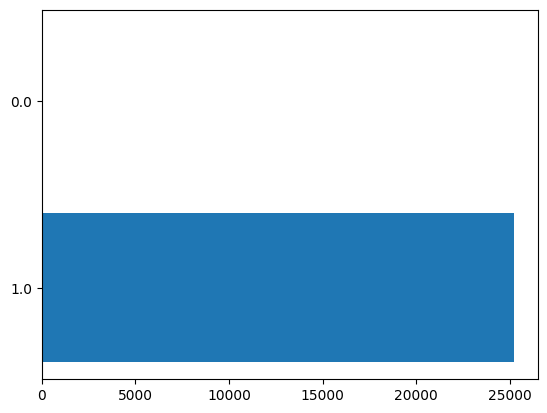

In [234]:

# Count the different values in the cmd_c column across all the dataframes
counter = countValues(dict, 'cmd_c')
print(counter)

plt.barh([str(k) for k in counter.keys()], counter.values())
plt.show()


The number of 0 values for the column cmd_c is irrelevant (when the executed command is not a check). For that reason, entries with these values should be dropped.

In [235]:
def dropNonChecks(dict):
    # Drop the rows that are not checks
    # dict: dictionary of dataframes
    # return: dataframe with the rows that are not checks removed
    total = 0
    for df in dict.values():
        # Filter rows with cmd_c != 0
        dfToDrop = df[df["cmd_c"] == 0]
        # Short circuit derivations
        for index, row in dfToDrop.iterrows():
            df = shortCircuit(df, index)
            logDrop(row["_id"], "being a non check (cmd_c = 0)")
            total += 1
    print(f"Total number of rows dropped: {total}")
    return dict

# Remove the rows with the value 0 in the cmd_c column
dropNonChecks(dict)

# Check
print(countValues(dict, 'cmd_c'))

Total number of rows dropped: 26
Counter({1.0: 25225})


#### original feature

In [236]:
def operateDFs(dict, op, arg):
    # Operate on each dataframe in a dictionary
    # dict: dictionary of dataframes
    # op: operation to perform
    # arg: argument to pass to the operation
    for df in dict.values():
        op(df, arg)

# Count the different values for the original column for each dataframe
countValuesOp = (lambda df, arg: print(df[arg].value_counts().to_dict()))
operateDFs(dict, countValuesOp, 'original')

{'9jPK8KBWzjFmBx4Hb': 4352}
{'FwCGymHmbqcziisH5': 981}
{'gAeD3MTGCCv8YNTaK': 2389}
{'JC8Tij8o8GZb99gEJ': 834}
{'jyS8Bmceejj9pLbTW': 577}
{'PQAJE67kz8w5NWJuM': 2925}
{'sDLK7uBCbgZon3znd': 2556}
{'WGdhwKZnCu7aKhXq9': 283}
{'YH3ANm7Y5Qe5dSYem': 4176}
{'zoEADeCW2b2suJB2k': 1990}
{'zRAn69AocpkmxXZnW': 4162}


Every dataframe has the same value for the original column. This column is irrelevant.

Now we will drop the irrelevant columns. 

In [237]:
# Drop columns that are not needed
dropColOp = (lambda df, arg: df.drop(columns=arg, axis=1, inplace=True))
colsToDrop = ["cmd_c", "cmd_i", "original", "msg", "theme"]

operateDFs(dict, dropColOp, colsToDrop)
operateDFs(challengeRows, dropColOp, colsToDrop) 

dict["9jPK8KBWzjFmBx4Hb"].head()

,_id,time,code,derivationOf,cmd_n,sat
1,tMWGrRkotYudAFPEn,2019-10-31 10:41:00,/**\n * Linear temporal logic revision exercis...,9jPK8KBWzjFmBx4Hb,prop1Ok,1.0
3,DzmkfBsnQCpc3gBqp,2019-10-31 10:41:25,/**\n * Linear temporal logic revision exercis...,tMWGrRkotYudAFPEn,prop1Ok,0.0
4,9vDQHbRTfAPrXNRE2,2019-10-31 10:41:43,/**\n * Linear temporal logic revision exercis...,9jPK8KBWzjFmBx4Hb,prop1Ok,0.0
5,DW3jnYaP6XS4K5X9J,2019-10-31 10:42:12,/**\n * Linear temporal logic revision exercis...,DzmkfBsnQCpc3gBqp,prop2Ok,0.0
6,T9w8XuQioW8bHnkMa,2019-10-31 10:42:22,/**\n * Linear temporal logic revision exercis...,DW3jnYaP6XS4K5X9J,prop2Ok,0.0


### Code cleaning

The code in this dataset comes with comments that can be removed.

In [238]:
import re # regular expressions

def cleanCode(code):
    # Remove comments and empty lines
    # code: string with the code
    # return: string with the code without comments and empty lines
    code = re.sub(r"(/\*(.|\n)*?\*/)|(//.*)|(--.*)", "", code) # remove comments
    code = re.sub(r"\n\n(?=\n)", "", code) # remove empty lines
    code = code.replace("\n", " ").replace("\t", " ")
    
    return " ".join(code.split()).strip()

def applyToCol(df, col, op):
    # Apply an operation to a column
    # df: dataframe
    # col: column to apply the operation
    # op: operation to apply
    # return: dataframe with the operation applied
    df[col] = df[col].apply(op)
    return df

# Clean the code column
cleanCodeOp = (lambda df, arg: applyToCol(df, arg, cleanCode))
operateDFs(dict, cleanCodeOp, "code")
operateDFs(challengeRows, cleanCodeOp, "code")

df1.head()


,_id,time,code,derivationOf,cmd_n,sat
1,tMWGrRkotYudAFPEn,2019-10-31 10:41:00,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1Ok,1.0
3,DzmkfBsnQCpc3gBqp,2019-10-31 10:41:25,var sig File { var link : lone File } var sig ...,tMWGrRkotYudAFPEn,prop1Ok,0.0
4,9vDQHbRTfAPrXNRE2,2019-10-31 10:41:43,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1Ok,0.0
5,DW3jnYaP6XS4K5X9J,2019-10-31 10:42:12,var sig File { var link : lone File } var sig ...,DzmkfBsnQCpc3gBqp,prop2Ok,0.0
6,T9w8XuQioW8bHnkMa,2019-10-31 10:42:22,var sig File { var link : lone File } var sig ...,DW3jnYaP6XS4K5X9J,prop2Ok,0.0


### cmd_n rename

Rename cmd_n so that it equals the predicate completed by the student.

In [239]:
def removeExtraSuffix(pred):
    return re.sub("OK|Ok|ok", "", pred)

remSuffixOp = (lambda df, arg: applyToCol(df, arg, removeExtraSuffix))
operateDFs(dict, remSuffixOp, "cmd_n")

df1.head()

,_id,time,code,derivationOf,cmd_n,sat
1,tMWGrRkotYudAFPEn,2019-10-31 10:41:00,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,1.0
3,DzmkfBsnQCpc3gBqp,2019-10-31 10:41:25,var sig File { var link : lone File } var sig ...,tMWGrRkotYudAFPEn,prop1,0.0
4,9vDQHbRTfAPrXNRE2,2019-10-31 10:41:43,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0
5,DW3jnYaP6XS4K5X9J,2019-10-31 10:42:12,var sig File { var link : lone File } var sig ...,DzmkfBsnQCpc3gBqp,prop2,0.0
6,T9w8XuQioW8bHnkMa,2019-10-31 10:42:22,var sig File { var link : lone File } var sig ...,DW3jnYaP6XS4K5X9J,prop2,0.0


# Feature Engineering

## Year column 

Extract year from time column.

In [240]:
dict["9jPK8KBWzjFmBx4Hb"].head()

,_id,time,code,derivationOf,cmd_n,sat
1,tMWGrRkotYudAFPEn,2019-10-31 10:41:00,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,1.0
3,DzmkfBsnQCpc3gBqp,2019-10-31 10:41:25,var sig File { var link : lone File } var sig ...,tMWGrRkotYudAFPEn,prop1,0.0
4,9vDQHbRTfAPrXNRE2,2019-10-31 10:41:43,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0
5,DW3jnYaP6XS4K5X9J,2019-10-31 10:42:12,var sig File { var link : lone File } var sig ...,DzmkfBsnQCpc3gBqp,prop2,0.0
6,T9w8XuQioW8bHnkMa,2019-10-31 10:42:22,var sig File { var link : lone File } var sig ...,DW3jnYaP6XS4K5X9J,prop2,0.0


In [241]:
def extractYear(date):
    # Extract the year from a date
    # date: string with the date
    # return: int with the year

    # Check if the date is in the format YYYY-MM-DD hh:mm:ss
    if "-" in date:
        return int(date[:4])
    else: # date is in the format DD/MM/YYYY, hh:mm:ss PM
        int(date.split(",")[0].split("/")[2])

# Extract the year from the date column
extractYearOp = (lambda df, arg: applyToCol(df, arg, extractYear))
operateDFs(dict, extractYearOp, "time")
operateDFs(challengeRows, extractYearOp, "time")

# Check
dict["9jPK8KBWzjFmBx4Hb"]["time"].value_counts()


2020.0    2840
2019.0    1199
2021.0     300
2022.0      12
Name: time, dtype: int64

## Expression column

Import Java library.

In [242]:
import jpype # Java

# Import the Java libraries
if not jpype.isJVMStarted():
    jpype.startJVM(classpath=['../lib/Parser/parser.jar'])

# Import the Java classes
CompUtil = jpype.JClass('edu.mit.csail.sdg.parser.CompUtil')
Reporter = jpype.JClass('edu.mit.csail.sdg.alloy4.A4Reporter')

Generate Expr column that contains the expression written by the student to the respective predicate.

In [243]:
# Import the Java classes
ExprParser = jpype.JClass('org.higena.A4FExprParser')
def getExpr(code: str, cmd: str):
    # Get the expression of a predicate
    # code: string with the code
    # cmd: predicate name
    # return: string with the expression of the predicate
    parser = ExprParser(code)
    return str(parser.parse(cmd)).strip()

def genExprColum(dict):
    # Iterate datasets 
    for df in dict.values():
        df["expr"] = df.apply(lambda x: getExpr(x["code"], x["cmd_n"]), axis=1)

genExprColum(dict)

In [244]:
# Check the results
dict["9jPK8KBWzjFmBx4Hb"].head()

,_id,time,code,derivationOf,cmd_n,sat,expr
1,tMWGrRkotYudAFPEn,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,1.0,
3,DzmkfBsnQCpc3gBqp,2019.0,var sig File { var link : lone File } var sig ...,tMWGrRkotYudAFPEn,prop1,0.0,no Trash and no Protected
4,9vDQHbRTfAPrXNRE2,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash and no Protected
5,DW3jnYaP6XS4K5X9J,2019.0,var sig File { var link : lone File } var sig ...,DzmkfBsnQCpc3gBqp,prop2,0.0,no File after some File
6,T9w8XuQioW8bHnkMa,2019.0,var sig File { var link : lone File } var sig ...,DW3jnYaP6XS4K5X9J,prop2,0.0,no File and after some File


## Add challenge code to dataset

Add submissions to the dataset that represent the initial state of the challenge (the empty submission) and the teacher's solution.

In [245]:
def genEmptySubmission(challengeDf): 
    # Generate an empty submission
    # challengeDf: dataframe with one row with the challenge
    # return: dataframe with one row with the empty submission for the challenge

    challengeRow = challengeDf # Copy the dictionary
    challengeRow["sat"] = [1.0] # Empty submission is incorrect
    challengeRow["expr"] = ["EMPTY"] # Empty submission has an empty expression
    challengeRow["derivationOf"] = [""] # Does not derive from any other challenge

    return challengeRow

def getSolutions(code):
    # Get the solutions of a challenge
    # code: string with the code
    # return: dictionary with the solutions where the key is the predicate name and the value is the solution expression

    result = {} # Initialize dictionary
    module = CompUtil.parseEverything_fromString(Reporter(), code)

    # Set keys of the dictionary: predicates to be completed by students (empty predicates)
    for fun in module.getAllFunc():
        if "$$Default" not in fun.label and fun.getBody().toString().equals("true"): # Empty predicate has the body "true"
            result[str(fun.label).removeprefix("this/")] = "" 

    # Get the solutions
    for fun in module.getAllFunc():
        label = str(fun.label).removeprefix("this/")
        if label in result: # Skip if predicate in dictionary
            continue

        # Check for variations of 'oracle' in label
        possible_keys = [label.removesuffix(suffix) for suffix in ["o", "O", "oracle"] if label.endswith(suffix)]
        for key in possible_keys:
            if key in result:
                result[key] = getExpr(code, label)
                break

    return result

def addChallengeRows(dict, challengeRows):
    # Add the challenge rows 
    # dict: dictionary of dataframes
    # challengeRows: dictionary of dataframes with the challenge rows
    # return: dictionary of dataframes with the challenge rows added

    # Iterate datasets
    for challenge in dict.keys():
        # Get the initial empty submission for the challenge and set its fields 
        challenge_row = genEmptySubmission(challengeRows[challenge])
        # Get the solutions of the challenge
        challenge_solutions = getSolutions(challenge_row["code"].values[0])

        # Gen the teacher solution
        solution_row = challenge_row.copy()
        solution_row["sat"] = [0.0] # Correct
        solution_row["derivationOf"] = [challenge]

        for pred, solution in challenge_solutions.items():
            # Set up and append the challenge empty row to the dataframe
            challenge_row["cmd_n"] = [pred]
            dict[challenge] = pd.concat([dict[challenge], challenge_row], ignore_index=True)

            # Set up and append the teacher solution row to the dataframe
            solution_row["expr"] = [solution] 
            solution_row["cmd_n"] = [pred]
            solution_row["_id"] = ["sol_" + pred]
            dict[challenge] = pd.concat([dict[challenge], solution_row], ignore_index=True)
        
    return dict

dict = addChallengeRows(dict, challengeRows)

In [246]:
# Check
df = dict["9jPK8KBWzjFmBx4Hb"]
df[df["expr"] == "EMPTY"].head()

,_id,time,code,derivationOf,cmd_n,sat,expr
4352,9jPK8KBWzjFmBx4Hb,2019.0,var sig File { var link : lone File } var sig ...,,prop1,1.0,EMPTY
4354,9jPK8KBWzjFmBx4Hb,2019.0,var sig File { var link : lone File } var sig ...,,prop2,1.0,EMPTY
4356,9jPK8KBWzjFmBx4Hb,2019.0,var sig File { var link : lone File } var sig ...,,prop3,1.0,EMPTY
4358,9jPK8KBWzjFmBx4Hb,2019.0,var sig File { var link : lone File } var sig ...,,prop4,1.0,EMPTY
4360,9jPK8KBWzjFmBx4Hb,2019.0,var sig File { var link : lone File } var sig ...,,prop5,1.0,EMPTY


In [247]:
df[df["_id"] == "sol_prop1"]

,_id,time,code,derivationOf,cmd_n,sat,expr
4353,sol_prop1,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash+Protected


## Remove Empty Submissions

Remove submissions with empty expression except for the inital submission.

In [248]:
def dropEmptySubmissions(dict):
    # Drop rows that are empty submissions
    # dict: dictionary of dataframes
    # return: dataframe without empty submissions
    total = 0
    for df in dict.values():
        # Filter rows with expr = ""
        rowsToDrop = df[df["expr"] == ""]
        # Short circuit derivations
        for index, row in rowsToDrop.iterrows():
            df = shortCircuit(df, index)
            logDrop(row["_id"], "being an empty submission.")
            total += 1
    print("Total empty submissions dropped: " + str(total))

def fixEmpty(expr):
    # Turn EMPTY expr to ""
    # expr: string with the expression
    # return: string with the expression fixed
    if expr == "EMPTY":
        return ""
    else:
        return expr

dropEmptySubmissions(dict)
# Turn EMPTY expr to "" 
fixEmptyOp = (lambda df, arg: applyToCol(df, arg, fixEmpty))
operateDFs(dict, fixEmptyOp, "expr")



Total empty submissions dropped: 1165


In [249]:
# Check
df = dict["9jPK8KBWzjFmBx4Hb"]
df[df["expr"] == ""].head()

,_id,time,code,derivationOf,cmd_n,sat,expr
4352,9jPK8KBWzjFmBx4Hb,2019.0,var sig File { var link : lone File } var sig ...,,prop1,1.0,
4354,9jPK8KBWzjFmBx4Hb,2019.0,var sig File { var link : lone File } var sig ...,,prop2,1.0,
4356,9jPK8KBWzjFmBx4Hb,2019.0,var sig File { var link : lone File } var sig ...,,prop3,1.0,
4358,9jPK8KBWzjFmBx4Hb,2019.0,var sig File { var link : lone File } var sig ...,,prop4,1.0,
4360,9jPK8KBWzjFmBx4Hb,2019.0,var sig File { var link : lone File } var sig ...,,prop5,1.0,


## Separate DFs by predicate

Separate by predicate.

In [250]:
def separateDerivations(df, pred, challenge):
    # Separate derivations that belong to different predicates using short circuiting
    # df: dataframe
    # pred: predicate
    # return: dataframe with independent derivations

    predDf = df[df["cmd_n"] == pred].copy() # Copy df filtered by predicate
    
    # Iterate over predDf 
    for index, row in predDf.iterrows():
        derId = row["derivationOf"] # Get the derivation of the row
        derDf = df[df["_id"] == derId] # Get the derivation row
        
        # Get nearest derivation with the same predicate
        # Loop ends upon finding a row/submission with the cmd_n == pred
        # or when the derivation is not present in the dataframe
        # or when the derivation is the challenge row
        while not derDf.empty and derDf.iloc[0]["cmd_n"] != pred and derDf.iloc[0]["_id"] != challenge: 
            # get previous derivation
            derDf = df[df["_id"] == derDf.iloc[0]["derivationOf"]] 

        
        # Update the derivationOf column
        if not derDf.empty:
            predDf.at[index, "derivationOf"] = derDf.iloc[0]["_id"]

    return predDf


def separateDFbyPred(dict):
    # Separate the dataframes by predicate
    # dict: dictionary of dataframes for each challenge
    # return: dictionary of dataframes for each challenge and each predicate: dict[challenge][predicate]
     
    # Dictionary of dataframes for each exercise
    allDfs = {}
    # Iterate over the dataframes
    for challenge, df in dict.items():
        allDfs[challenge] = {} # init the challenge dictionary
        challengePreds = list(df["cmd_n"].value_counts().index.tolist()) # Get the list of functions from the challenge
        # Iterate over the exercises
        for pred in challengePreds:
            # Separate derivations that belong to different predicates using short circuiting 
            allDfs[challenge][pred] = separateDerivations(df, pred, challenge).copy()
            
    return allDfs

allDfs = separateDFbyPred(dict)

In [251]:
# Check
for challenge, preds in allDfs.items():
    print(challenge, list(preds.keys()))

allDfs["9jPK8KBWzjFmBx4Hb"]["prop1"].head() 

9jPK8KBWzjFmBx4Hb ['prop5', 'prop12', 'prop6', 'prop10', 'prop8', 'prop18', 'prop4', 'prop2', 'prop11', 'prop9', 'prop14', 'prop1', 'prop7', 'prop17', 'prop16', 'prop20', 'prop13', 'prop3', 'prop19', 'prop15']
FwCGymHmbqcziisH5 ['prop3', 'prop5', 'prop2', 'prop1', 'prop4', 'prop6', 'prop9', 'prop7', 'prop15', 'prop8', 'prop14', 'prop11', 'prop17', 'prop13', 'prop10', 'prop16', 'prop12', 'prop18']
gAeD3MTGCCv8YNTaK ['weaklyConnected', 'undirected', 'complete', 'oriented', 'acyclic', 'noLoops', 'stonglyConnected', 'transitive']
JC8Tij8o8GZb99gEJ ['Inv4', 'Inv3', 'Inv1', 'Inv2']
jyS8Bmceejj9pLbTW ['Inv4', 'Inv2', 'Inv1', 'Inv3']
PQAJE67kz8w5NWJuM ['inv7', 'inv6', 'inv5', 'inv1', 'inv10', 'inv9', 'inv4', 'inv2', 'inv3', 'inv8']
sDLK7uBCbgZon3znd ['inv7', 'inv1', 'inv6', 'inv5', 'inv10', 'inv4', 'inv2', 'inv9', 'inv8', 'inv3', 'check$1']
WGdhwKZnCu7aKhXq9 ['Inv4', 'Inv3', 'Inv2', 'Inv1']
YH3ANm7Y5Qe5dSYem ['inv11', 'inv14', 'inv12', 'inv5', 'inv4', 'inv15', 'inv3', 'inv8', 'inv9', 'inv1', '

,_id,time,code,derivationOf,cmd_n,sat,expr
1,DzmkfBsnQCpc3gBqp,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash and no Protected
2,9vDQHbRTfAPrXNRE2,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash and no Protected
10,mFPY8XCBj8o2awxwt,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,historically (no Trash and no Protected)
11,pvxf9z6k6FWgnsQCM,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash and no Protected
14,dfK55Kdye3jMnDez6,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash no Protected


## Add AST column

Parse challenges files first.

In [265]:
def parseChallenges(path):
    # Parse the challenges
    # path: path to the challenges
    # return: dictionary of parsed challenges with the name as key 
    challenges = {}
    for challenge in os.listdir(path):
        if challenge.endswith(".als"):
            challenges[challenge[:-4]] = CompUtil.parseEverything_fromFile(Reporter(), None, path + challenge)
    return challenges

parsed_challenges = parseChallenges("data/challenges/")

In [266]:
ASTParser = jpype.JClass('org.higena.A4FParser')
SyntaxError = jpype.JClass('edu.mit.csail.sdg.alloy4.ErrorSyntax')
TypeError = jpype.JClass('edu.mit.csail.sdg.alloy4.ErrorType')

def logError(id, challenge, error, expr):
    # Log an error
    # id: id of the submission
    # challenge: id of the challenge
    # error: error message
    # expr: expression that failed
    file = open("data/astError.txt", "a")
    file.write("\n- Submission: " + id + " Challenge: " + challenge + " Expr: " + expr + "\n\t" + str(error) + "\n")
    file.close()

def parseExpr(id, expr, fullCode, predID, challenge, parsedChallenge):
    # Parse an expression
    # expr: string with the expression
    # fullCode: string with the full code
    # predID: id of the predicate
    # challenge: id of the challenge
    # parsedChallenge: parsed challenge module
    # return: parsed expression

    # Handle empty submissions (challenge code)
    if expr == "":
        return ""

    parsed = None
    try:
        parsed = str(ASTParser.parse(expr, parsedChallenge))
    except Exception as e:
        # Try to parse the full code
        try:
            parsed = str(ASTParser.parse(fullCode, predID))
        except Exception as e:
            logError(id, challenge, e, expr)

    return parsed

def addASTsColumns(allDfs, parsed_challenges):
    # Add the ASTs columns
    # allDfs: dictionary of dataframes for each challenge and each predicate
    # parsed_challenges: dictionary of parsed challenges
    # return: dictionary of dataframes for each challenge and each predicate with the ASTs columns

    # Iterate over the challenges
    for challenge, cmdDfs in allDfs.items():
        # Get parsed challenge

        # Iterate over the submission for each command
        for cmd, df in cmdDfs.items():
            df["ast"] = df[["_id", "expr", "code", "cmd_n"]].apply(lambda x: parseExpr(x["_id"], x["expr"], x["code"], x["cmd_n"], challenge, parsed_challenges[challenge]), axis=1)

# Add the ASTs columns
addASTsColumns(allDfs, parsed_challenges)

# Check
allDfs["9jPK8KBWzjFmBx4Hb"]["prop1"].head()

,_id,time,code,derivationOf,cmd_n,sat,expr,ast
1,DzmkfBsnQCpc3gBqp,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash and no Protected,{AND{no{this/Protected}}{no{this/Trash}}}
2,9vDQHbRTfAPrXNRE2,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash and no Protected,{AND{no{this/Protected}}{no{this/Trash}}}
10,mFPY8XCBj8o2awxwt,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,historically (no Trash and no Protected),{historically{AND{no{this/Protected}}{no{this/...
11,pvxf9z6k6FWgnsQCM,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash and no Protected,{AND{no{this/Protected}}{no{this/Trash}}}
14,dfK55Kdye3jMnDez6,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash no Protected,{AND{no{this/Protected}}{no{this/Trash}}}


Clean submissions without ASTs. (With syntax errors)

In [267]:
def removeEmptyASTs(allDfs):
    # Remove the empty ASTs
    # allDfs: dictionary of dataframes for each challenge and each predicate
    # return: dictionary of dataframes for each challenge and each predicate

    # Iterate over the challenges
    for cmdDfs in allDfs.values():
       cmdDfs = dropNulls(cmdDfs, "ast") 
           
    print("Removed submissions with no ASTs.")
    return allDfs

allDfs = removeEmptyASTs(allDfs)

Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 1
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Removed submissions with no ASTs.


# Split data

Split test and train data. Train data stands from 2019 to 2021.

In [268]:
# Initialize the dictionaries 
trainDfs = {}
testDfs = {}

# Iterate over the challenges
for challenge, cmdDfs in allDfs.items(): 
    trainDfs[challenge] = {}
    testDfs[challenge] = {}
    # Iterate over the predicates
    for cmd, df in cmdDfs.items():
        trainDfs[challenge][cmd] = df[df["time"] <= 2021].copy()
        testDfs[challenge][cmd] = df[df["time"] > 2021].copy()

# Check
trainDfs["9jPK8KBWzjFmBx4Hb"]["prop1"]["time"].value_counts()

2020.0    105
2019.0     33
2021.0     11
Name: time, dtype: int64

# Export data

In [270]:
def exportData(allDfs, path):
    # Export the dataframes to csv files
    # allDfs: dictionary of dataframes for each challenge and each predicate 
    # path: path to export the dataframes

    # Iterate over the challenges
    for challenge, cmdDfs in allDfs.items():
        # Create folder if it does not exist
        folder = path + challenge + "/"
        if os.path.exists(folder):
            # Delete all files
            fileList = [f for f in os.listdir(folder)]
            for f in fileList:
                os.remove(os.path.join(folder, f))
        else:
            # Create folder
            os.makedirs(folder)

        # Iterate over the submission for each commantime/timed
        for cmd, df in cmdDfs.items():
            # Export dataframe to csv
            file = folder + cmd + ".csv"
            df.to_csv(file, index=False)

# Export the dataframes to db
exportData(trainDfs, "../graph/data/train/")
exportData(testDfs, "../graph/data/test/")
exportData(allDfs, "../graph/data/all/")  

In [271]:
# Check
df = pd.read_csv("../graph/data/all/9jPK8KBWzjFmBx4Hb/prop1.csv")
df.head()

,_id,time,code,derivationOf,cmd_n,sat,expr,ast
0,DzmkfBsnQCpc3gBqp,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash and no Protected,{AND{no{this/Protected}}{no{this/Trash}}}
1,9vDQHbRTfAPrXNRE2,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash and no Protected,{AND{no{this/Protected}}{no{this/Trash}}}
2,mFPY8XCBj8o2awxwt,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,historically (no Trash and no Protected),{historically{AND{no{this/Protected}}{no{this/...
3,pvxf9z6k6FWgnsQCM,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash and no Protected,{AND{no{this/Protected}}{no{this/Trash}}}
4,dfK55Kdye3jMnDez6,2019.0,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,prop1,0.0,no Trash no Protected,{AND{no{this/Protected}}{no{this/Trash}}}


## Import data

In [2]:
import os
import pandas as pd
import collections
import seaborn as sns

def importCsvs(path):
    # Import the csv files
    # path: path to the csv files
    # return: dictionary of dataframes for each challenge and each predicate

    allDfs = {} # Dictionary of dataframes for each challenge and each predicate

    # Iterate over the folders
    for folder in os.listdir(path):
        # Iterate over the csv files
        for file in os.listdir(path + folder):
            # Read the csv file
            df = pd.read_csv(path + folder + "/" + file)
            # Add the dataframe to the dictionary
            if folder not in allDfs:
                allDfs[folder] = {}
            allDfs[folder][file[:-4]] = df

    return allDfs

# Import the csv files
allDfs = importCsvs("../graph/data/all/")
trainDfs = importCsvs("../graph/data/train/")
testDfs = importCsvs("../graph/data/test/")

# Data analysis

Count number of submissions, correct and incorrect. 

In [8]:
def analyzeData(allDfs):
    analysisDf = pd.DataFrame({"Challenge": [], "Predicate": [], "NumSubmissions": [], "NumCorrect": [], "NumIncorrect": []})
    counter = collections.Counter()

    for challenge, cmdDfs in allDfs.items():
        for cmd, df in cmdDfs.items():
        # Update counter
            count = df["sat"].value_counts().to_dict()
            counter.update(count)
            analysisDf.loc[len(analysisDf)] = [
                challenge,
                cmd,
                len(df),
                len(df[df["sat"] == 0.0]),
                len(df[df["sat"] == 1.0])
            ]

    pd.set_option('display.max_rows', None)
    # Sort by number of submissions
    analysisDf.sort_values(by=['NumSubmissions'], ascending=False)

    print("Total number of submissions: " + str(analysisDf["NumSubmissions"].sum()))
    print("Total number of correct submissions: " + str(analysisDf["NumCorrect"].sum()))
    print("Total number of incorrect submissions: " + str(analysisDf["NumIncorrect"].sum()))

    # Show plot    
    sns.barplot(data=pd.DataFrame.from_dict(counter, orient="index").reset_index(), x="index", y=0, palette=["green", "red"])

    return analysisDf

## Analyze all submissions

Total number of submissions: 24289
Total number of correct submissions: 10646
Total number of incorrect submissions: 13643


,Challenge,Predicate,NumSubmissions,NumCorrect,NumIncorrect
0,9jPK8KBWzjFmBx4Hb,prop1,153,126,27
1,9jPK8KBWzjFmBx4Hb,prop10,349,54,295
2,9jPK8KBWzjFmBx4Hb,prop11,216,82,134
3,9jPK8KBWzjFmBx4Hb,prop12,409,37,372
4,9jPK8KBWzjFmBx4Hb,prop13,121,82,39
5,9jPK8KBWzjFmBx4Hb,prop14,162,67,95
6,9jPK8KBWzjFmBx4Hb,prop15,101,50,51
7,9jPK8KBWzjFmBx4Hb,prop16,147,51,96
8,9jPK8KBWzjFmBx4Hb,prop17,148,48,100
9,9jPK8KBWzjFmBx4Hb,prop18,241,46,195


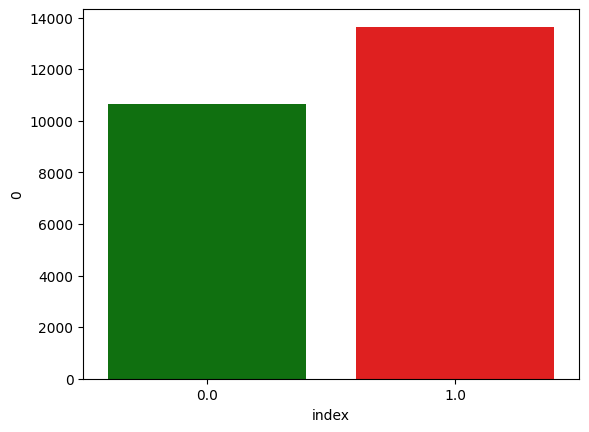

In [9]:
analyzeData(allDfs)

## Analyze train data

Total number of submissions: 21242
Total number of correct submissions: 9331
Total number of incorrect submissions: 11911


,Challenge,Predicate,NumSubmissions,NumCorrect,NumIncorrect
0,9jPK8KBWzjFmBx4Hb,prop1,149,124,25
1,9jPK8KBWzjFmBx4Hb,prop10,348,53,295
2,9jPK8KBWzjFmBx4Hb,prop11,216,82,134
3,9jPK8KBWzjFmBx4Hb,prop12,408,37,371
4,9jPK8KBWzjFmBx4Hb,prop13,121,82,39
5,9jPK8KBWzjFmBx4Hb,prop14,162,67,95
6,9jPK8KBWzjFmBx4Hb,prop15,101,50,51
7,9jPK8KBWzjFmBx4Hb,prop16,147,51,96
8,9jPK8KBWzjFmBx4Hb,prop17,148,48,100
9,9jPK8KBWzjFmBx4Hb,prop18,241,46,195


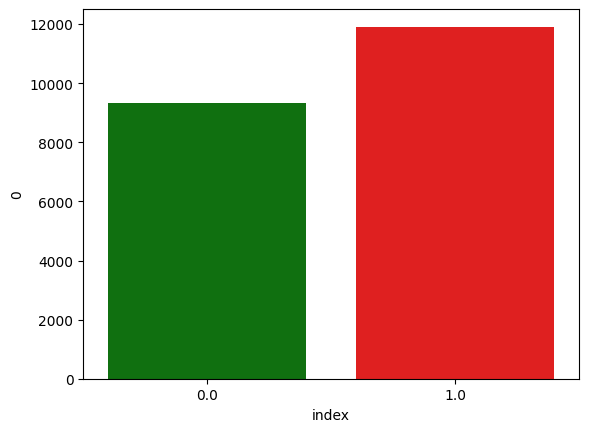

In [10]:
analyzeData(trainDfs)

## Analyze test data

Total number of submissions: 2675
Total number of correct submissions: 1149
Total number of incorrect submissions: 1526


,Challenge,Predicate,NumSubmissions,NumCorrect,NumIncorrect
0,9jPK8KBWzjFmBx4Hb,prop1,4,2,2
1,9jPK8KBWzjFmBx4Hb,prop10,1,1,0
2,9jPK8KBWzjFmBx4Hb,prop11,0,0,0
3,9jPK8KBWzjFmBx4Hb,prop12,1,0,1
4,9jPK8KBWzjFmBx4Hb,prop13,0,0,0
5,9jPK8KBWzjFmBx4Hb,prop14,0,0,0
6,9jPK8KBWzjFmBx4Hb,prop15,0,0,0
7,9jPK8KBWzjFmBx4Hb,prop16,0,0,0
8,9jPK8KBWzjFmBx4Hb,prop17,0,0,0
9,9jPK8KBWzjFmBx4Hb,prop18,0,0,0


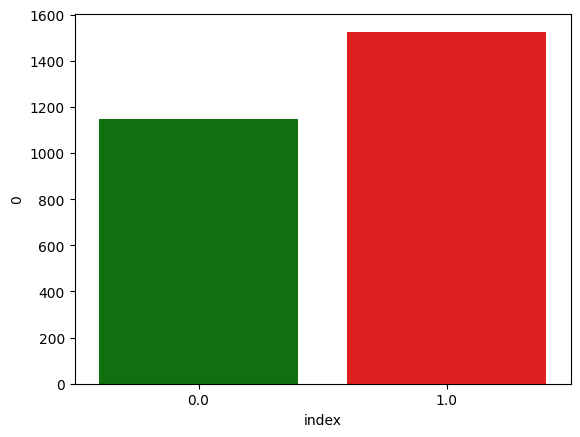

In [11]:
analyzeData(testDfs)